In [81]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import math
import numpy as np
from sklearn import preprocessing
#Plots
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [8]:
#fecha de inicio y fin del analisis
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2019,9,1)

In [9]:
df = web.DataReader('AAPL','yahoo',start,end)

In [10]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


Rolling Mean (Moving Average) - to determine trend

In [26]:
close_px=df['Adj Close']
mavg = close_px.rolling(window=100).mean() #Calculate de MA for the last 100 days

In [27]:
#adjust the size of matplotlib
mpl.rc('figure', figsize=(11,7))

In [28]:
mpl.__version__

'3.1.0'

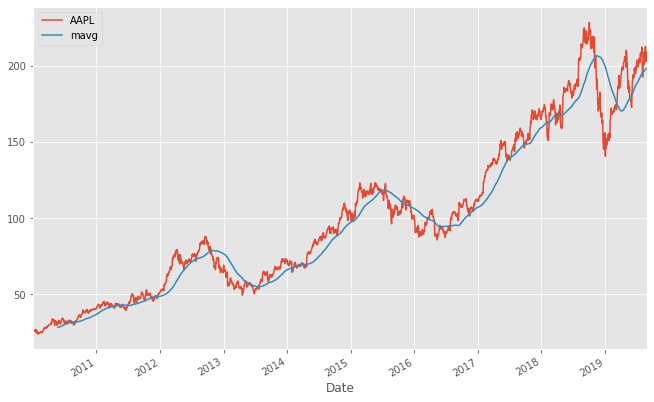

In [29]:
#adjust the style of matplotlib
mpl.style.use('ggplot')
close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

Return Deviation - to determine risk and return

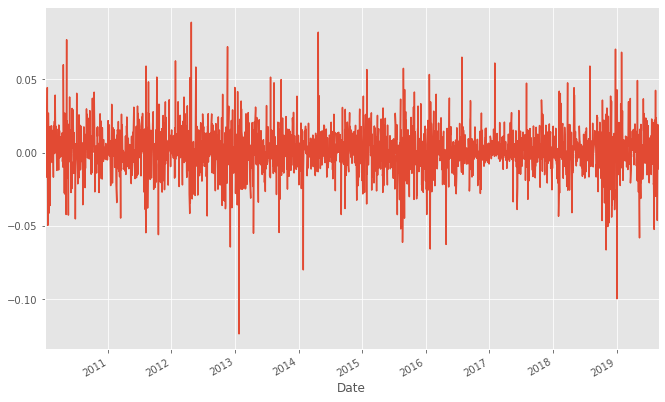

In [30]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

ANALYSING THE COMPETITORS STOCKS

In [31]:
#hoW one company performs in relative with its competitor.
dfcomp= web.DataReader(['AAPL','GE','GOOG','IBM','MSFT'], 'yahoo',start=start, end=end)['Adj Close']

In [34]:
dfcomp.head()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2010-01-04,26.681330,10.906911,312.204773,98.142967,24.443624
2010-01-05,26.727465,10.963388,310.829926,96.957375,24.451517
2010-01-06,26.302330,10.906911,302.994293,96.327530,24.301458
2010-01-07,26.253704,11.471671,295.940735,95.994110,24.048725
2010-01-08,26.428249,11.718755,299.885956,96.957375,24.214581


CORRELATION ANALYSIS

In [35]:
#How much the price changes compared to the previous day
retscomp = dfcomp.pct_change()

In [39]:
#Knowing the correlation will help us see the whether the returns are affected by other stocks' returns.
corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.321165,0.462883,0.385814,0.457645
GE,0.321165,1.000000,0.332437,0.437855,0.361893
GOOG,0.462883,0.332437,1.000000,0.406329,0.538604
IBM,0.385814,0.437855,0.406329,1.000000,0.491927
MSFT,0.457645,0.361893,0.538604,0.491927,1.000000


Text(0, 0.5, 'Returns GE')

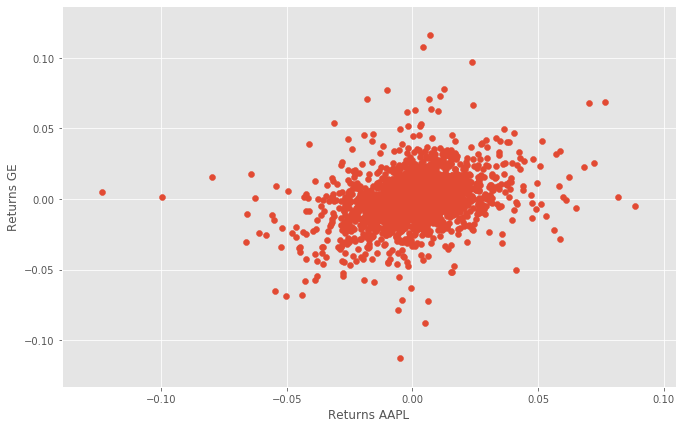

In [40]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002381E43FCF8>,
      dtype=object)

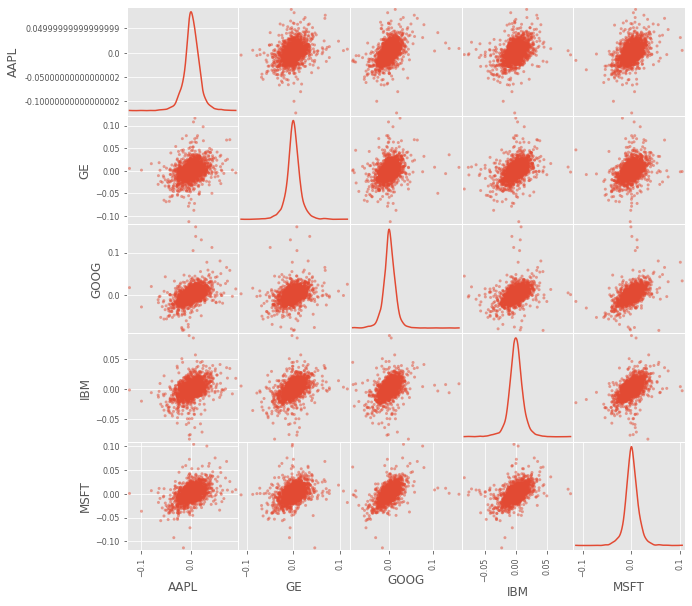

In [42]:
#Scatter_matrix to visualize posible correlations among competing stocks
pd.plotting.scatter_matrix(retscomp, diagonal = 'kde', figsize=(10,10))

([<matplotlib.axis.YTick at 0x2381e64d320>,
 <a list of 5 Text yticklabel objects>)

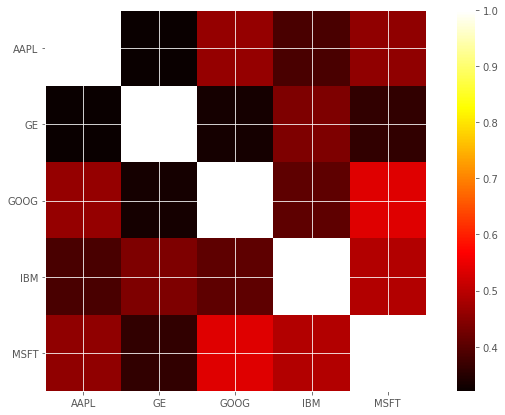

In [43]:
#Heat map to prove positive correlations
plt.imshow(corr, cmap='hot', interpolation= 'none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns)

STOCK RETURNS RATE AND RISK

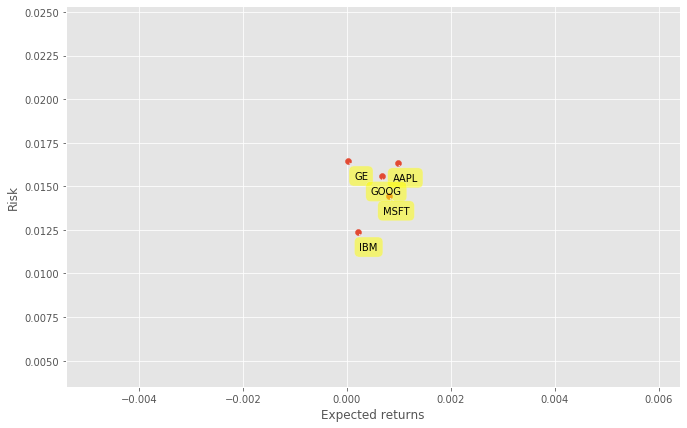

In [54]:
#Extract the average of returns (Return Rate) and the standard deviation of returns (risk)
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')

for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(label,
                 xy = (x, y),
                 xytext = (20, -20), 
                 textcoords = 'offset points',
                 ha = 'right',
                 va = 'bottom',
                 bbox = dict(boxstyle='round,pad=0.5', fc='yellow',alpha= 0.5),
                 arrowprops = dict(arrowstyle= "->", connectionstyle= 'arc3,rad=0'))

PREDICTING STOCKS PRICE

In [55]:
#Machine Learning models to predict our stocks:
# Simple linear Analysis
# Quadratic Discriminant Analysis (QDA)
# KNN

In [59]:
#High low percentage and percentage change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT']=(df['High']-df['Low'])/df['Close']*100
dfreg['PCT_change']=(df['Close']-df['Open'])/df['Open']*100

In [67]:
##Pre-processing & Cross Validation##
#Drop missing values
dfreg.isnull().sum() #No hay missing values

Adj Close     0
Volume        0
HL_PCT        0
PCT_change    0
dtype: int64

In [70]:
#Separete 1 percent of the data to forcast
forecast_out=int(math.ceil(0.01*len(dfreg)))

In [77]:
#Separating the label here, we want to predit the AdjClose
forecast_col='Adj Close'
dfreg['label']=dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'],1))

In [82]:
#Scale the x so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [84]:
#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately= X[-forecast_out:]
X= X[:-forecast_out]

In [87]:
#Separate label and identiy it as y
y=np.array(dfreg['label'])
y= y[:-forecast_out]

MODEL GENERATION

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [95]:
##Simple linear analysis & quadratic discriminant analysis##
#Linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [96]:
#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [98]:
#Quadratic Regression 3
clfpoly3= make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [99]:
##KNN Regression##
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

EVALUATION

In [100]:
confidencereg = clfreg.score(X_test,y_test)
condifencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3= clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test,y_test)

print("The linear regression confidence is: ", confidencereg)
print("The quadratic regression 2 confidence is: ", condifencepoly2)
print("The quadratic regression 3 confidence is: ", confidencepoly3)
print("The knn regression confidence is: ", confidenceknn)

The linear regression confidence is:  0.9641352605867888
The quadratic regression 2 confidence is:  0.9659724763029276
The quadratic regression 3 confidence is:  0.955910380004231
The knn regression confidence is:  0.9541057221176918


In [111]:
#Forecast
forecast_reg = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

PLOTTING THE PREDICTION

In [104]:
last_date=dfreg.iloc[-1].name

In [107]:
last_unix=last_date
next_unix= last_unix + datetime.timedelta(days=1)

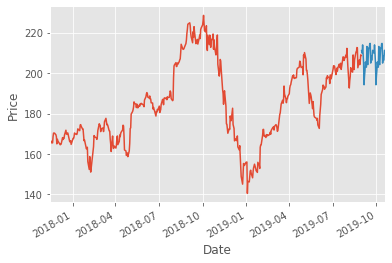

In [117]:
for i in forecast_reg:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date]=[np.nan for _ in range (len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()